# Modeling Expected Goals For

In [273]:
# Standard Packages
import pandas as pd
import numpy as np
import warnings
import re

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Modeling Packages
## Modeling Prep
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, \
GridSearchCV, RandomizedSearchCV

## SKLearn Data Prep Modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
PolynomialFeatures, PowerTransformer, Normalizer, MaxAbsScaler

from sklearn.impute import SimpleImputer

## SKLearn Classification Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


## SKLearn Pipeline Setup
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## SKLearn Model Optimization
from sklearn.feature_selection import RFE, f_regression

## Boosting
from xgboost import XGBRegressor
from xgboost import XGBClassifier

## SKLearn Metrics
### Classification Scoring/Evaluation
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, \
ConfusionMatrixDisplay, log_loss, confusion_matrix, RocCurveDisplay, make_scorer, roc_auc_score


In [ ]:
# Notebook Config
## Suppress Python Warnings (Future, Deprecation)
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Suppress Pandas Warnings (SettingWithCopy)
pd.options.mode.chained_assignment = None

## Pandas Display Config
pd.options.display.max_columns = None
pd.options.display.width = None

## Display SKLearn estimators as diagrams
from sklearn import set_config
set_config(display= 'diagram')

In [82]:
# # 2020-2021 NHL shot data retrieved from moneypuck.com 
# shots_df = pd.read_csv('project-data/shots_2020.csv')
# shots_df

In [83]:
# Use 2021-22 data, as 2020-2021 was highly impacted by covid
s21_shots_df = pd.read_csv('project-data/shots_2021.csv')
s21_shots_df

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,42.520583,61.0,61.0,-32.0,32.0,-8.400000,0,0,0,5,PIT,0,33.4,37.0,25.0,31.000000,25.000000,25.0,2,3,37,37,25,31,25,25,31,37,25,31,25,25,13.038405,SHOT,20001,0,8477465,Tristan Jarry,0,0,0,5,TBL,0,0,10,1.0,0,HIT,0.0,0.0,HOME,50,50,-39,-39,AWAYZONE,0,1,91,0,C,2021,R,Steven Stamkos,8474564.0,34,25,22.000000,4.0,4.0,34.000000,25.0,16.600000,2,3,34,4,4,34,25,25,4,4,4,34,25,4,-48.814075,48.814075,0.000000,0.000000,0,42.520583,0,1,0,0,0,0,0,0,WRIST,1.0,1.303840,HOME,TBL,63,-21,25,10,0,61,61,0.202514,0.009192,0.445979,0.289830,0.023891,0.028594,0.718082,-32,-32
1,1,30.610456,-65.0,65.0,19.0,19.0,21.400000,0,0,0,5,PIT,0,3.2,8.0,8.0,0.000000,0.000000,3.2,2,3,8,8,8,0,0,8,0,8,8,0,0,0,130.080744,SHOT,20001,0,8476883,Andrei Vasilevskiy,0,0,0,5,TBL,0,0,15,0.0,0,BLOCK,0.0,0.0,HOME,60,-60,-17,17,HOMEZONE,1,1,23,0,L,2021,L,Brock McGinn,8476934.0,41,41,24.600000,0.0,0.0,41.000000,41.0,24.600000,2,3,41,0,0,41,41,41,0,0,0,41,41,0,-38.367485,38.367485,38.367485,2.019341,0,30.610456,0,0,0,0,1,0,0,0,WRIST,1.0,6.846355,AWAY,PIT,104,0,41,19,13,-65,65,0.285948,0.031353,0.303080,0.325607,0.026384,0.027629,0.793188,19,-19
2

In [84]:
s21_shots_df.info(verbose=True, show_counts=True) # data is rather robust and clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121471 entries, 0 to 121470
Data columns (total 124 columns):
 #    Column                                                 Non-Null Count   Dtype  
---   ------                                                 --------------   -----  
 0    shotID                                                 121471 non-null  int64  
 1    arenaAdjustedShotDistance                              121471 non-null  float64
 2    arenaAdjustedXCord                                     121471 non-null  float64
 3    arenaAdjustedXCordABS                                  121471 non-null  float64
 4    arenaAdjustedYCord                                     121471 non-null  float64
 5    arenaAdjustedYCordAbs                                  121471 non-null  float64
 6    averageRestDifference                                  121471 non-null  float64
 7    awayEmptyNet                                           121471 non-null  int64  
 8    awayPenalty1Length    

In [85]:
s21_shots_df.describe()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,game_id,goal,goalieIdForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventShotAngle,lastEventShotDistance,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,season,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotWasOnGoal,speedFromLastEvent,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
count,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.00000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,1.214710e+05,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.0,1.214680e+05,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.00000

In [86]:
# Check for missing values
pd.set_option('display.max_rows', 125)
s21_shots_df.isna().sum()

shotID                                                     0
arenaAdjustedShotDistance                                  0
arenaAdjustedXCord                                         0
arenaAdjustedXCordABS                                      0
arenaAdjustedYCord                                         0
arenaAdjustedYCordAbs                                      0
averageRestDifference                                      0
awayEmptyNet                                               0
awayPenalty1Length                                         0
awayPenalty1TimeLeft                                       0
awaySkatersOnIce                                           0
awayTeamCode                                               0
awayTeamGoals                                              0
defendingTeamAverageTimeOnIce                              0
defendingTeamAverageTimeOnIceOfDefencemen                  0
defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff      0
defendingTeamAverageTime

In [87]:
# Features with missing values and counts
    # goalieNameForShot                                        800
    # playerPositionThatDidEvent                                 4
    # shooterLeftRight                                           3
    # shooterName                                                3
    # shooterPlayerId                                            3
# do nothing as these features will be dropped

In [88]:
# check if postseason included
s21_shots_df['isPlayoffGame'].value_counts()

0    113158
1      8313
Name: isPlayoffGame, dtype: int64

In [89]:
# check period column in case shootout attempts are included
s21_shots_df['period'].value_counts()

2    41584
1    39317
3    38793
4     1716
5       47
6       14
Name: period, dtype: int64

In [90]:
# check how many extra periods are attributable to the post season
len(s21_shots_df.loc[(s21_shots_df['period'] >= 5) & (s21_shots_df['isPlayoffGame'] == 1)])

61

In [91]:
# All instances of a 5th and 6th period are attributable to the post season
# Shootouts have already been scrubbed

In [92]:
# check event types
s21_shots_df['event'].value_counts() # all events are shots

SHOT    80180
MISS    32594
GOAL     8697
Name: event, dtype: int64

In [93]:
# check goal values
s21_shots_df['goal'].value_counts() # binary with 1 representing a goal scored

0    112774
1      8697
Name: goal, dtype: int64

In [94]:
# check goal imbalance
s21_shots_df['goal'].value_counts(normalize=True) # very imbalanced

0    0.928403
1    0.071597
Name: goal, dtype: float64

In [95]:
columns_to_keep = ['goal','isHomeTeam', 'timeSinceLastEvent', 'shotAngleAdjusted', 'xCordAdjusted', 'yCordAdjusted', 
                   'shotAnglePlusRebound', 'shotAngleReboundRoyalRoad', 'shotType', 'shotOnEmptyNet', 
                   'shotAnglePlusReboundSpeed', 'shotRebound', 'shotRush', 'speedFromLastEvent', 
                   'lastEventxCord_adjusted', 'lastEventyCord_adjusted', 'distanceFromLastEvent',
                   'arenaAdjustedShotDistance', 'arenaAdjustedYCordAbs', 'arenaAdjustedXCordABS', 
                   'homeSkatersOnIce', 'awaySkatersOnIce', 'awayPenalty1TimeLeft', 'homePenalty1TimeLeft', 
                   'offWing']

In [96]:
shots_df = s21_shots_df[columns_to_keep]
shots_df

,goal,isHomeTeam,timeSinceLastEvent,shotAngleAdjusted,xCordAdjusted,yCordAdjusted,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotAnglePlusReboundSpeed,shotRebound,shotRush,speedFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,distanceFromLastEvent,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,homeSkatersOnIce,awaySkatersOnIce,awayPenalty1TimeLeft,homePenalty1TimeLeft,offWing
0,0,1.0,10,48.814075,61,-32,0.000000,0,WRIST,0,0.000000,0,0,1.303840,50,-39,13.038405,42.520583,32.0,61.0,5,5,0,0,0
1,0,0.0,19,38.367485,65,-19,38.367485,0,WRIST,0,2.019341,0,0,6.846355,-60,17,130.080744,30.610456,19.0,65.0,5,5,0,0,1
2,0,1.0,4,18.434949,8,27,0.000000,0,WRIST,0,0.000000,0,0,15.103807,67,40,60.415230,85.381497,27.0,8.0,5,5,0,0,1
3,0,0.0,2,7.853313,60,4,0.000000,0,WRIST,0,0.000000,0,0,9.861541,70,-13,19.723083,29.274562,4.0,60.0,5,5,0,0,0
4,0,1.0,19,8.746162,63,4,0.000000,0,WRIST,0,0.000000,0,0,7.080855,-69,-22,134.536240,26.305893,4.0,63.0,5,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121466,0,1.0,11,23.198591,61,-12,0.000000,0,SNAP,0,0.000000,0,0,1.164204,69,-22,12.806248,30.463092,12.0,61.0,5,5,0,0,1
121467,0,1.0,12,10.619655,73,-3,0.000000,0,TIP,0,0.000000,0,0,4.883362,20,22,58.600341,16.278821,3.0,73.0,5,5,0,0,1
121468,0,0.0,16,5.572198,48,-4,0.000000,0,SNAP,0,0.000000,0,0,1.629801,74,-2,26.076810,41.194660,4.0,48.0,5,5,0,0,1
121469,0,1.0,5,0.000000,72,0,0.000000,0,TIP,0,0.000000,0,0,1.077033,74,-5,5.385165,17.000000,0.0,72.0,6,5,0,0,0


In [97]:
# add column for game_strength_state
shots_df['game_strength_state'] = ''

In [98]:
# Add even strength game strength values
shots_df.loc[(shots_df['homeSkatersOnIce'] == 3) & (shots_df['awaySkatersOnIce'] == 3), 
             'game_strength_state'] = 'EV3'
shots_df.loc[(shots_df['homeSkatersOnIce'] == 4) & (shots_df['awaySkatersOnIce'] == 4), 
             'game_strength_state'] = 'EV4'
shots_df.loc[(shots_df['homeSkatersOnIce'] == 5) & (shots_df['awaySkatersOnIce'] == 5), 
             'game_strength_state'] = 'EV5'
shots_df

,goal,isHomeTeam,timeSinceLastEvent,shotAngleAdjusted,xCordAdjusted,yCordAdjusted,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotAnglePlusReboundSpeed,shotRebound,shotRush,speedFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,distanceFromLastEvent,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,homeSkatersOnIce,awaySkatersOnIce,awayPenalty1TimeLeft,homePenalty1TimeLeft,offWing,game_strength_state
0,0,1.0,10,48.814075,61,-32,0.000000,0,WRIST,0,0.000000,0,0,1.303840,50,-39,13.038405,42.520583,32.0,61.0,5,5,0,0,0,EV5
1,0,0.0,19,38.367485,65,-19,38.367485,0,WRIST,0,2.019341,0,0,6.846355,-60,17,130.080744,30.610456,19.0,65.0,5,5,0,0,1,EV5
2,0,1.0,4,18.434949,8,27,0.000000,0,WRIST,0,0.000000,0,0,15.103807,67,40,60.415230,85.381497,27.0,8.0,5,5,0,0,1,EV5
3,0,0.0,2,7.853313,60,4,0.000000,0,WRIST,0,0.000000,0,0,9.861541,70,-13,19.723083,29.274562,4.0,60.0,5,5,0,0,0,EV5
4,0,1.0,19,8.746162,63,4,0.000000,0,WRIST,0,0.000000,0,0,7.080855,-69,-22,134.536240,26.305893,4.0,63.0,5,5,0,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121466,0,1.0,11,23.198591,61,-12,0.000000,0,SNAP,0,0.000000,0,0,1.164204,69,-22,12.806248,30.463092,12.0,61.0,5,5,0,0,1,EV5
121467,0,1.0,12,10.619655,73,-3,0.000000,0,TIP,0,0.000000,0,0,4.883362,20,22,58.600341,16.278821,3.0,73.0,5,5,0,0,1,EV5
121468,0,0.0,16,5.572198,48,-4,0.000000,0,SNAP,0,0.000000,0,0,1.629801,74,-2,26.076810,41.194660,4.0,48.0,5,5,0,0,1,EV5
121469,0,1.0,5,0.000000,72,0,0.000000,0,TIP,0,0.000000,0,0,1.077033,74,-5,5.385165,17.000000,0.0,72.0,6,5,0,0,0,


In [99]:
# Add Home team game_strength_state
shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'state_5v4'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 3), 'game_strength_state'] = 'state_5v3'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 3), 'game_strength_state'] = 'state_4v3'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 6) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'state_6v5'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 6) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'state_6v4'


In [100]:
# Add Away team game_strength_state
shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'state_5v4'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 3) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'state_5v3'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 3) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'state_4v3'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 6), 'game_strength_state'] = 'state_6v5'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 6), 'game_strength_state'] = 'state_6v4'

In [101]:
# Add shorthandeed game_strength_state
shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] < shots_df['awaySkatersOnIce']),
             'game_strength_state'] = 'SH'
shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['awaySkatersOnIce'] < shots_df['homeSkatersOnIce']),
             'game_strength_state'] = 'SH'

In [102]:
shots_df['game_strength_state'].value_counts()

EV5          95457
state_5v4    16058
SH            3902
state_6v5     2137
EV4           1495
EV3           1322
state_5v3      535
state_6v4      294
state_4v3      263
                 8
Name: game_strength_state, dtype: int64

In [103]:
shots_df.loc[shots_df['game_strength_state'] == ''] #drop these rows as they are very rare game states

,goal,isHomeTeam,timeSinceLastEvent,shotAngleAdjusted,xCordAdjusted,yCordAdjusted,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotAnglePlusReboundSpeed,shotRebound,shotRush,speedFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,distanceFromLastEvent,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,homeSkatersOnIce,awaySkatersOnIce,awayPenalty1TimeLeft,homePenalty1TimeLeft,offWing,game_strength_state
42838,1,0.0,13,52.431408,69,-26,0.000000,0,SLAP,0,0.000000,0,0,3.692308,69,22,48.000000,32.802439,26.0,69.0,3,6,0,0,1,
48051,0,1.0,15,59.036243,83,-10,0.000000,0,TIP,0,0.000000,0,0,2.328567,69,22,34.928498,12.000000,10.0,83.0,6,3,54,0,1,
48053,0,1.0,25,27.439728,37,-27,0.000000,0,SLAP,0,0.000000,0,0,1.808867,63,10,45.221676,59.000000,27.0,37.0,6,3,21,0,0,
54327,0,1.0,7,55.713123,74,-22,17.587633,0,WRIST,0,2.512519,0,0,1.317078,83,-20,9.219544,26.627054,22.0,74.0,6,6,0,0,0,
66234,0,1.0,4,7.696052,52,5,0.000000,0,WRIST,0,0.000000,0,0,13.059958,0,0,52.239832,42.000000,6.0,47.0,6,3,0,0,0,
70470,0,1.0,3,33.690068,65,16,0.000000,0,WRIST,0,0.000000,0,0,8.000000,65,-8,24.000000,29.000000,16.0,65.0,4,2,72,72,1,
75188,0,0.0,33,45.000000,79,-10,0.000000,0,TIP,0,0.000000,0,0,4.877658,-74,40,160.962729,12.000000,8.0,81.0,5,7,0,0,1,
83083,0,1.0,19,33.690068,44,-30,0.000000,0,SLAP,0,0.000000,0,0,2.265605,87,-32,43.046487,52.000000,29.0,46.0,7,5,0,0,1,


In [104]:
shots_df = shots_df.loc[shots_df['game_strength_state'] != '']
shots_df

,goal,isHomeTeam,timeSinceLastEvent,shotAngleAdjusted,xCordAdjusted,yCordAdjusted,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotAnglePlusReboundSpeed,shotRebound,shotRush,speedFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,distanceFromLastEvent,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,homeSkatersOnIce,awaySkatersOnIce,awayPenalty1TimeLeft,homePenalty1TimeLeft,offWing,game_strength_state
0,0,1.0,10,48.814075,61,-32,0.000000,0,WRIST,0,0.000000,0,0,1.303840,50,-39,13.038405,42.520583,32.0,61.0,5,5,0,0,0,EV5
1,0,0.0,19,38.367485,65,-19,38.367485,0,WRIST,0,2.019341,0,0,6.846355,-60,17,130.080744,30.610456,19.0,65.0,5,5,0,0,1,EV5
2,0,1.0,4,18.434949,8,27,0.000000,0,WRIST,0,0.000000,0,0,15.103807,67,40,60.415230,85.381497,27.0,8.0,5,5,0,0,1,EV5
3,0,0.0,2,7.853313,60,4,0.000000,0,WRIST,0,0.000000,0,0,9.861541,70,-13,19.723083,29.274562,4.0,60.0,5,5,0,0,0,EV5
4,0,1.0,19,8.746162,63,4,0.000000,0,WRIST,0,0.000000,0,0,7.080855,-69,-22,134.536240,26.305893,4.0,63.0,5,5,0,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121466,0,1.0,11,23.198591,61,-12,0.000000,0,SNAP,0,0.000000,0,0,1.164204,69,-22,12.806248,30.463092,12.0,61.0,5,5,0,0,1,EV5
121467,0,1.0,12,10.619655,73,-3,0.000000,0,TIP,0,0.000000,0,0,4.883362,20,22,58.600341,16.278821,3.0,73.0,5,5,0,0,1,EV5
121468,0,0.0,16,5.572198,48,-4,0.000000,0,SNAP,0,0.000000,0,0,1.629801,74,-2,26.076810,41.194660,4.0,48.0,5,5,0,0,1,EV5
121469,0,1.0,5,0.000000,72,0,0.000000,0,TIP,0,0.000000,0,0,1.077033,74,-5,5.385165,17.000000,0.0,72.0,6,5,0,0,0,state_6v5


In [105]:
# check datatypes
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121463 entries, 0 to 121470
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   goal                       121463 non-null  int64  
 1   isHomeTeam                 121463 non-null  float64
 2   timeSinceLastEvent         121463 non-null  int64  
 3   shotAngleAdjusted          121463 non-null  float64
 4   xCordAdjusted              121463 non-null  int64  
 5   yCordAdjusted              121463 non-null  int64  
 6   shotAnglePlusRebound       121463 non-null  float64
 7   shotAngleReboundRoyalRoad  121463 non-null  int64  
 8   shotType                   121458 non-null  object 
 9   shotOnEmptyNet             121463 non-null  int64  
 10  shotAnglePlusReboundSpeed  121463 non-null  float64
 11  shotRebound                121463 non-null  int64  
 12  shotRush                   121463 non-null  int64  
 13  speedFromLastEvent         12

In [369]:
shot_counts = shots_df.shotType.value_counts()
shot_counts

WRIST    68000
SLAP     16410
SNAP     15529
BACK      8985
TIP       8402
DEFL      3129
WRAP      1003
Name: shotType, dtype: int64

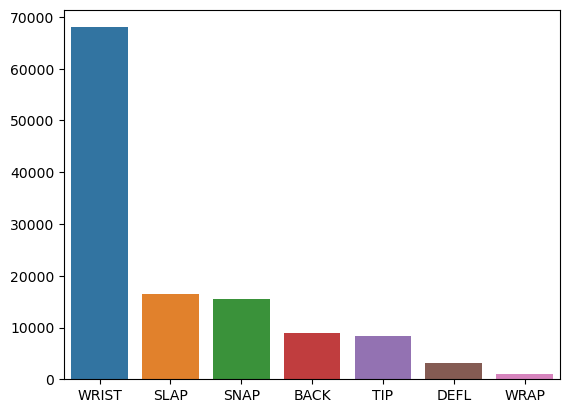

In [370]:
plot=sns.barplot(x = shot_counts.index, y= shot_counts.values)

In [362]:
goals_scored = s21_shots_df['goal'] == 1
goals_by_type = goals_scored.groupby(shots_df['shotType']).sum().sort_values(ascending=False).reset_index()

goals_by_type

,shotType,goal
0,WRIST,4547
1,SNAP,1356
2,BACK,834
3,SLAP,828
4,TIP,804
5,DEFL,280
6,WRAP,43


In [ ]:
shots_merged = 

In [342]:
goals_by_type[1]

1356

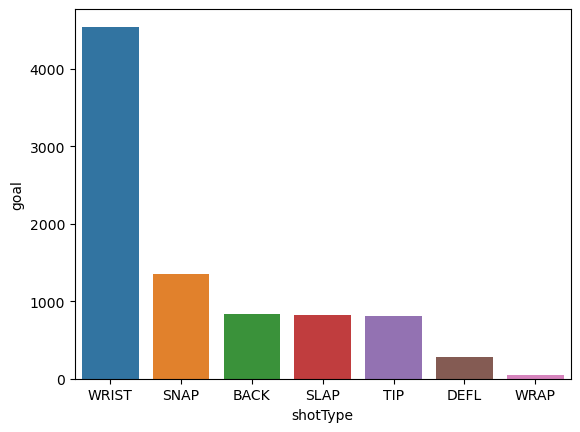

In [345]:
plot=sns.barplot(x = goals_by_type['shotType'],
              y = goals_by_type['goal']) #.sort_values(ascending=False))
# plot.set_xticklabels(plot.get_xticklabels(),rotation=30)

In [ ]:
goals_by_type_percentage = 

In [107]:
shots_df.loc[shots_df['shotType'].isna()]

,goal,isHomeTeam,timeSinceLastEvent,shotAngleAdjusted,xCordAdjusted,yCordAdjusted,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotAnglePlusReboundSpeed,shotRebound,shotRush,speedFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,distanceFromLastEvent,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,homeSkatersOnIce,awaySkatersOnIce,awayPenalty1TimeLeft,homePenalty1TimeLeft,offWing,game_strength_state
27087,1,0.0,22,4.969741,66,-2,0.000000,0,NaN,1,0.000000,0,0,3.001377,0,0,66.030296,23.000000,2.0,66.0,6,5,0,0,0,SH
31300,1,1.0,4,8.130102,82,-1,0.000000,0,NaN,0,0.000000,0,0,41.414068,-79,38,165.656271,7.071068,1.0,82.0,5,5,0,0,1,EV5
63230,1,1.0,6,0.000000,0,0,0.000000,0,NaN,1,0.000000,0,0,15.041609,87,-24,90.249654,89.000000,0.0,0.0,5,6,0,0,0,SH
96000,1,1.0,3,59.036243,86,5,53.325650,0,NaN,0,17.775217,1,0,2.687419,79,1,8.062258,5.830952,5.0,86.0,5,5,0,0,1,EV5
102112,0,0.0,1,41.185925,81,7,60.984802,1,NaN,0,60.984802,1,0,48.877398,39,-18,48.877398,13.000000,9.0,79.0,5,5,0,0,0,EV5


In [108]:
# Drop the 7 rows missing shot type data
shots_df = shots_df.dropna(subset=['shotType'])
shots_df

,goal,isHomeTeam,timeSinceLastEvent,shotAngleAdjusted,xCordAdjusted,yCordAdjusted,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotAnglePlusReboundSpeed,shotRebound,shotRush,speedFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,distanceFromLastEvent,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,homeSkatersOnIce,awaySkatersOnIce,awayPenalty1TimeLeft,homePenalty1TimeLeft,offWing,game_strength_state
0,0,1.0,10,48.814075,61,-32,0.000000,0,WRIST,0,0.000000,0,0,1.303840,50,-39,13.038405,42.520583,32.0,61.0,5,5,0,0,0,EV5
1,0,0.0,19,38.367485,65,-19,38.367485,0,WRIST,0,2.019341,0,0,6.846355,-60,17,130.080744,30.610456,19.0,65.0,5,5,0,0,1,EV5
2,0,1.0,4,18.434949,8,27,0.000000,0,WRIST,0,0.000000,0,0,15.103807,67,40,60.415230,85.381497,27.0,8.0,5,5,0,0,1,EV5
3,0,0.0,2,7.853313,60,4,0.000000,0,WRIST,0,0.000000,0,0,9.861541,70,-13,19.723083,29.274562,4.0,60.0,5,5,0,0,0,EV5
4,0,1.0,19,8.746162,63,4,0.000000,0,WRIST,0,0.000000,0,0,7.080855,-69,-22,134.536240,26.305893,4.0,63.0,5,5,0,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121466,0,1.0,11,23.198591,61,-12,0.000000,0,SNAP,0,0.000000,0,0,1.164204,69,-22,12.806248,30.463092,12.0,61.0,5,5,0,0,1,EV5
121467,0,1.0,12,10.619655,73,-3,0.000000,0,TIP,0,0.000000,0,0,4.883362,20,22,58.600341,16.278821,3.0,73.0,5,5,0,0,1,EV5
121468,0,0.0,16,5.572198,48,-4,0.000000,0,SNAP,0,0.000000,0,0,1.629801,74,-2,26.076810,41.194660,4.0,48.0,5,5,0,0,1,EV5
121469,0,1.0,5,0.000000,72,0,0.000000,0,TIP,0,0.000000,0,0,1.077033,74,-5,5.385165,17.000000,0.0,72.0,6,5,0,0,0,state_6v5


In [109]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121458 entries, 0 to 121470
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   goal                       121458 non-null  int64  
 1   isHomeTeam                 121458 non-null  float64
 2   timeSinceLastEvent         121458 non-null  int64  
 3   shotAngleAdjusted          121458 non-null  float64
 4   xCordAdjusted              121458 non-null  int64  
 5   yCordAdjusted              121458 non-null  int64  
 6   shotAnglePlusRebound       121458 non-null  float64
 7   shotAngleReboundRoyalRoad  121458 non-null  int64  
 8   shotType                   121458 non-null  object 
 9   shotOnEmptyNet             121458 non-null  int64  
 10  shotAnglePlusReboundSpeed  121458 non-null  float64
 11  shotRebound                121458 non-null  int64  
 12  shotRush                   121458 non-null  int64  
 13  speedFromLastEvent         12

In [ ]:
# Check correlation of selected features
plt.figure(figsize=(20,10))
cor = shots_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [111]:
shots_df.corr().sort_values('goal')

,goal,isHomeTeam,timeSinceLastEvent,shotAngleAdjusted,xCordAdjusted,yCordAdjusted,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotOnEmptyNet,shotAnglePlusReboundSpeed,shotRebound,shotRush,speedFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,distanceFromLastEvent,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,homeSkatersOnIce,awaySkatersOnIce,awayPenalty1TimeLeft,homePenalty1TimeLeft,offWing
arenaAdjustedShotDistance,-0.159274,-0.016761,0.047815,-0.182928,-0.942075,0.017017,-0.100762,-0.037926,0.048856,-0.157389,-0.217549,0.001695,-0.038165,-0.030524,0.004298,0.005268,1.000000,0.590378,-0.947619,0.061542,0.073907,-0.034806,-0.023415,-0.143048
arenaAdjustedYCordAbs,-0.140692,-0.017398,0.040926,0.547959,-0.330879,0.013381,0.018225,-0.007082,0.014748,-0.064065,-0.148914,-0.007993,0.006368,-0.039023,0.003242,0.087198,0.590378,1.000000,-0.334509,0.057855,0.067658,-0.036753,-0.028535,-0.090961
shotAngleAdjusted,-0.046107,-0.007015,0.006107,1.000000,0.443527,-0.010211,0.151187,0.019900,-0.016299,0.103049,0.027377,-0.009066,0.033653,-0.013818,-0.001130,0.090004,-0.182928,0.547959,0.446281,0.019953,0.020836,-0.012854,-0.014052,0.075778
timeSinceLastEvent,-0.043644,0.003695,1.000000,0.006107,-0.038152,-0.008733,-0.068224,-0.060323,-0.001849,-0.202267,-0.229031,-0.039049,-0.402057,-0.206977,-0.007057,0.190687,0.047815,0.040926,-0.038922,-0.059100,-0.057726,0.010618,0.013855,0.005430
homePenalty1TimeLeft,-0.037047,-0.139510,0.013855,-0.014052,0.015823,-0.007512,-0.010703,-0.004008,-0.010850,-0.012372,-0.006224,-0.005650,-0.040237,0.060303,0.010900,-0.064700,-0.023415,-0.028535,0.016303,-0.574233,-0.026085,0.082601,1.000000,0.053410
awaySkatersOnIce,-0.015658,-0.173348,-0.057726,0.020836,-0.058878,0.007495,-0.015773,-0.019594,0.121031,0.000769,-0.001760,0.012059,0.058647,-0.043896,-0.006330,0.053522,0.073907,0.067658,-0.058837,0.302257,1.000000,-0.583531,-0.026085,-0.057955
distanceFromLastEvent,-0.014520,-0.013339,0.190687,0.090004,0.030419,-0.005067,-0.130546,-0.153376,0.027952,-0.138897,-0.189292,0.049403,0.284685,-0.891811,-0.024569,1.000000,0.005268,0.087198,0.028941,0.038786,0.053522,-0.089640,-0.064700,-0.022594
homeSkatersOnIce,-0.013205,0.166335,-0.059100,0.019953,-0.047522,0.010975,-0.008058,-0.015221,0.113803,0.005569,0.000938,0.007840,0.046698,-0.032031,-0.002050,0.038786,0.061542,0.057855,-0.047449,1.000000,0.302257,-0.022045,-0.574233,-0.057511
yCordAdjusted,-0.006217,0.001808,-0.008733,-0.010211,-0.016053,1.000000,0.000076,0.002087,-0.000266,0.003802,0.003735,0.004989,0.000883,-0.002997,0.043831,-0.005067,0.017017,0.013381,-0.016002,0.010975,0.007495,-0.006682,-0.007512,-0.167652
lastEventyCord_adjusted,-0.004205,0.002280,-0.007057,-0.001130,-0.003822,0.043831,-0.012404,-0.012205,0.006188,-0.010687,-0.008663,-0.002862,-0.007732,0.022782,1.000000,-0.024569,0.004298,0.003242,-0.003381,-0.002050,-0.006330,0.015647,0.010900,-0.014137


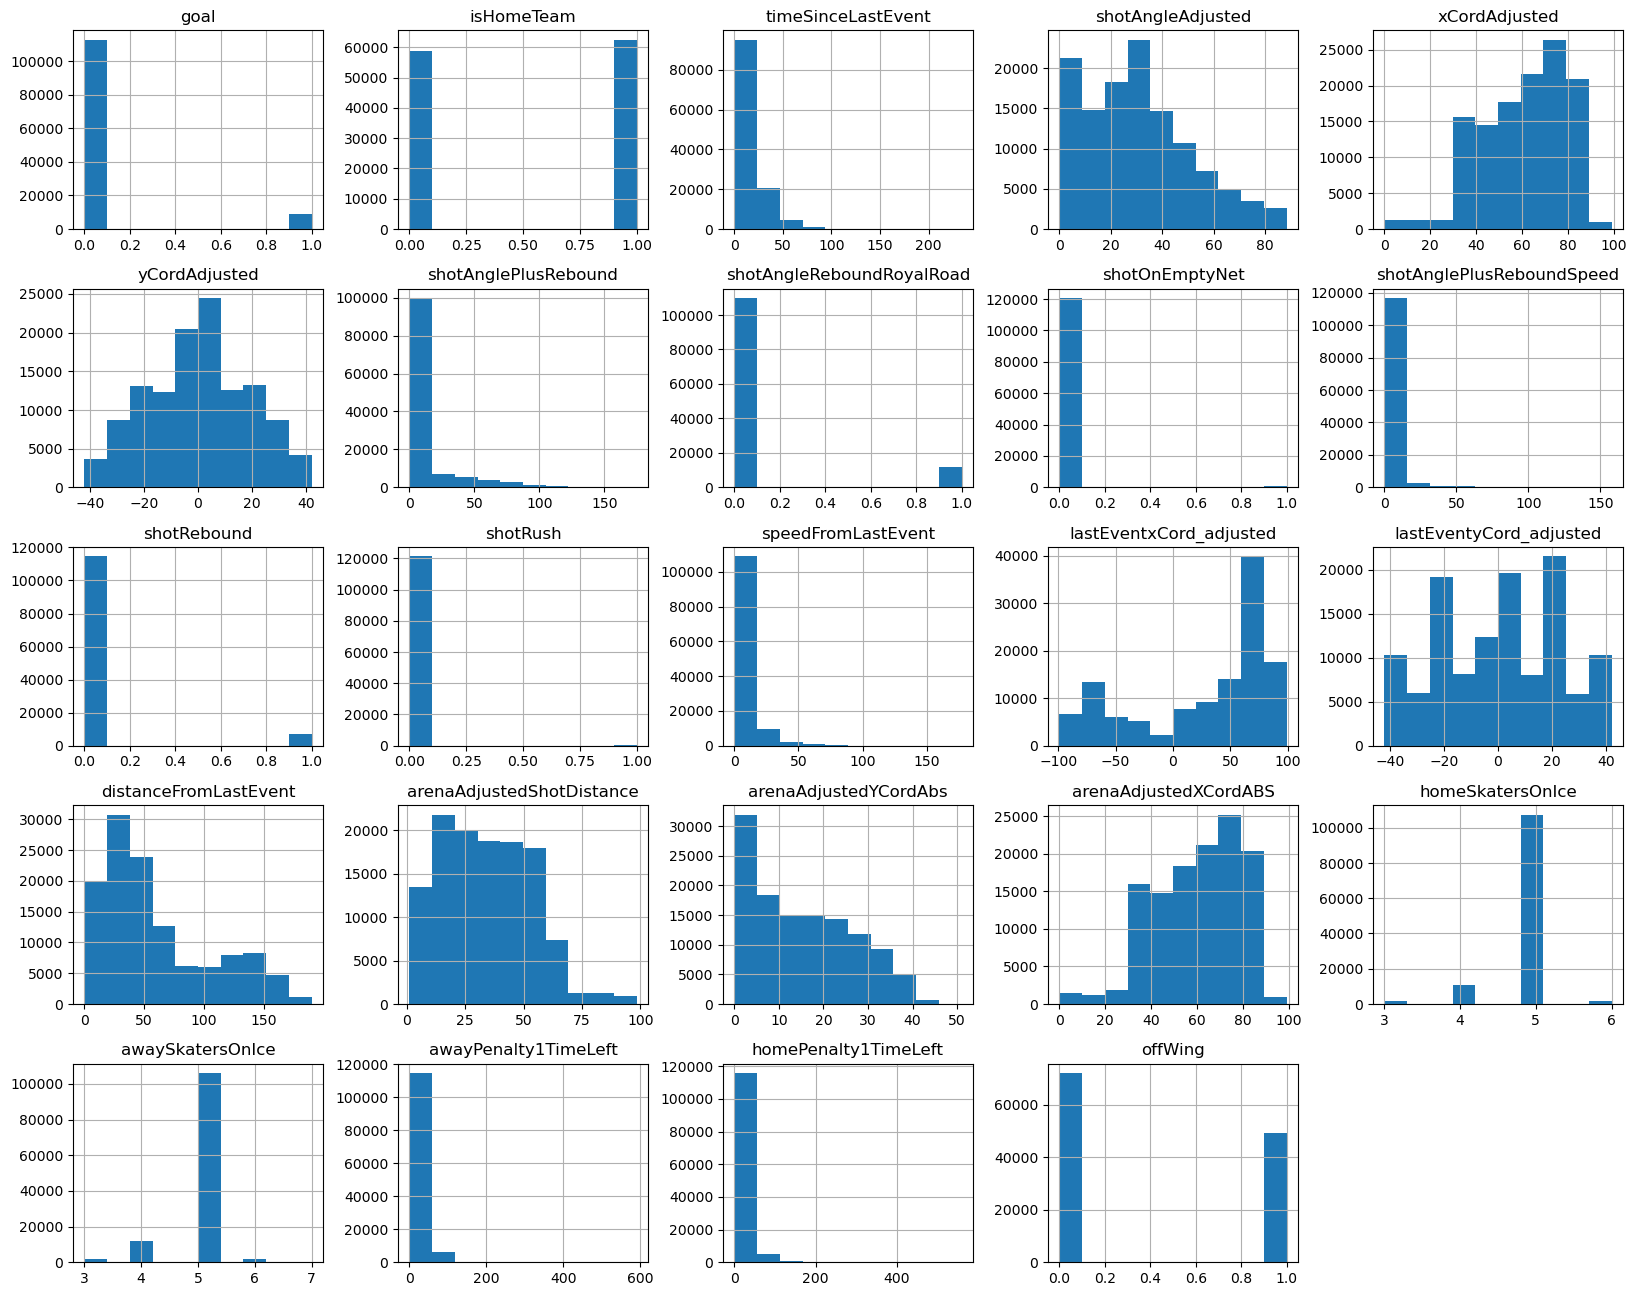

In [112]:
# Visualize features
shots_df.hist(bins=10, figsize=(20, 16))
plt.show()

# Baseline 

In [113]:
shots_df.goal.value_counts(normalize=True) # Baseline will predict no goal scord 92.8% of the time

0    0.928436
1    0.071564
Name: goal, dtype: float64

<AxesSubplot: xlabel='goal', ylabel='count'>

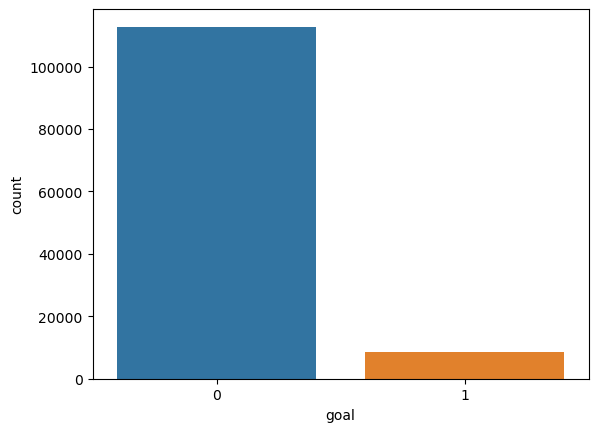

In [114]:
# Vizualize target variable distribution
sns.countplot(x='goal', data=shots_df)

In [115]:
# Establish Baseline accuracy score
baseline_pred = np.ones(shots_df.shape[0])
accuracy_score(shots_df['goal'],baseline_pred)

0.07156383276523572

In [116]:
# Establish baseline log loss as that is the industry standard metric for xG models
baseline_probs = np.repeat(shots_df['goal'].value_counts(normalize=True)[1], shots_df.shape[0])
log_loss(shots_df['goal'], baseline_probs)

0.25766544118178614

In [117]:
baseline_probs

array([0.07156383, 0.07156383, 0.07156383, ..., 0.07156383, 0.07156383,
       0.07156383])

# Modeling 

## Build Pipeline

In [118]:
# Seperate target variable 'goal' from feature set
# and perform a stratified test_train_split due to high imbalance 
X = shots_df.drop(['goal'], axis = 1)
y = shots_df['goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state= 42)

# Instantiate SMOTE

In [119]:
# Assign training sets of numeric and categorical columns to respective variables
num_features = X_train.select_dtypes(['int', 'float']).columns
cat_features = X_train.select_dtypes(['object']).columns

In [182]:
# Establish pipelines for each feature type
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])

In [122]:
# pass the pipelines to columntransformer
ct = ColumnTransformer(transformers=
    [("numpipe", numeric_pipeline, num_features),
     ("nominalpipe", nominal_pipeline, cat_features)])


In [123]:
num_features

Index(['isHomeTeam', 'timeSinceLastEvent', 'shotAngleAdjusted',
       'xCordAdjusted', 'yCordAdjusted', 'shotAnglePlusRebound',
       'shotAngleReboundRoyalRoad', 'shotOnEmptyNet',
       'shotAnglePlusReboundSpeed', 'shotRebound', 'shotRush',
       'speedFromLastEvent', 'lastEventxCord_adjusted',
       'lastEventyCord_adjusted', 'distanceFromLastEvent',
       'arenaAdjustedShotDistance', 'arenaAdjustedYCordAbs',
       'arenaAdjustedXCordABS', 'homeSkatersOnIce', 'awaySkatersOnIce',
       'awayPenalty1TimeLeft', 'homePenalty1TimeLeft', 'offWing'],
      dtype='object')

In [124]:
ct_df = pd.DataFrame(ct.fit_transform(X_train))
ct_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,0.973104,-0.916193,0.242589,1.147198,0.257873,-0.166390,-0.326268,-0.082916,0.089528,4.087193,-0.045233,-0.574335,0.886321,0.337261,-1.239754,-1.370559,-0.926174,1.169527,0.271629,0.286806,-0.281152,-0.252934,1.209644,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.027640,-0.174279,0.953674,0.436269,-1.299304,-0.434251,-0.326268,-0.082916,-0.265915,-0.244667,-0.045233,-0.728975,0.700634,-0.987258,-1.274788,0.195176,1.203036,0.252173,-2.338996,0.286806,-0.281152,4.789076,1.209644,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.027640,0.635082,0.201714,0.108148,-0.977130,-0.434251,-0.326268,-0.082916,-0.265915,-0.244667,-0.045233,-0.591673,0.700634,0.955370,-0.435841,0.248436,0.582016,-0.179523,0.271629,0.286806,-0.281152,-0.252934,-0.826690,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.027640,-0.444066,-0.192725,-0.001225,0.741134,-0.434251,-0.326268,-0.082916,-0.265915,-0.244667,-0.045233,0.711325,-1.780822,1.176123,1.727868,-0.161406,-0.127721,0.036325,0.271629,0.286806,-0.281152,-0.252934,-0.826690,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.973104,0.635082,-1.424829,-1.149649,-0.064302,-0.434251,-0.326268,-0.082916,-0.265915,-0.244667,-0.045233,-0.609089,0.700634,-0.987258,-0.537142,0.834302,-1.281043,-1.150839,0.271629,0.286806,-0.281152,-0.252934,-0.826690,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91088,-1.027640,-0.578959,0.470550,0.819077,0.580047,-0.434251,-0.326268,-0.082916,-0.265915,-0.244667,-0.045233,1.248893,-1.628896,-0.987258,1.926460,-0.816774,-0.305155,0.737831,0.271629,0.286806,-0.281152,-0.252934,-0.826690,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
91089,0.973104,-0.241726,-0.217544,-0.930901,1.170700,-0.434251,-0.326268,-0.082916,-0.265915,-0.244667,-0.045233,-0.347907,0.700634,-0.987258,-0.214170,0.887562,0.582016,-0.934991,0.271629,0.286806,-0.281152,-0.252934,-0.826690,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
91090,0.973104,0.500188,-0.800571,0.217522,0.311568,-0.434251,-0.326268,-0.082916,-0.265915,-0.244667,-0.045233,-0.557710,0.751276,-1.737819,-0.324694,-0.603732,-0.837457,0.360097,0.271629,0.286806,-0.281152,-0.252934,1.209644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
91091,-1.027640,3.805078,-0.326586,-0.329346,-0.816042,-0.434251,-0.326268,-0.082916,-0.265915,-0.244667,-0.045233,-0.677064,-0.126518,0.955370,-0.207078,0.248436,0.049714,-0.395371,-2.338996,0.286806,-0.281152,-0.205812,-0.826690,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [125]:
ct 

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['isHomeTeam', 'timeSinceLastEvent', 'shotAngleAdjusted',
       'xCordAdjusted', 'yCordAdjusted', 'shotAnglePlusRebound',
       'shotAngleReboundRoyalRoad', 'shotOnEmptyNet',
       'shotAnglePlusReboundSpeed', 'shotRebound', 'shotRush',
       'speedFromLastEvent', 'lastEventxCord_adjusted'...
       'arenaAdjustedShotDistance', 'arenaAdjustedYCordAbs',
       'arenaAdjustedXCordABS', 'homeSkatersOnIce', 'awaySkatersOnIce',
       'awayPenalty1TimeLeft', 'homePenalty1TimeLeft', 'offWing'],
      dtype='object')),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(sparse_output=False)),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 Index(['shotType', 'game_strength_state'], dtype='object'))])

In [126]:
# get feature names after encoding
feature_names = list(nominal_pipeline.named_steps['onehotenc'].fit(X_train[cat_features]).get_feature_names_out())

# confirm features
feature_names

['shotType_BACK',
 'shotType_DEFL',
 'shotType_SLAP',
 'shotType_SNAP',
 'shotType_TIP',
 'shotType_WRAP',
 'shotType_WRIST',
 'game_strength_state_EV3',
 'game_strength_state_EV4',
 'game_strength_state_EV5',
 'game_strength_state_SH',
 'game_strength_state_state_4v3',
 'game_strength_state_state_5v3',
 'game_strength_state_state_5v4',
 'game_strength_state_state_6v4',
 'game_strength_state_state_6v5']

In [127]:
import re
# removes the OHE strings at front end of feature names
def clean_ohe_names(feature_list):
    extracted_names = []
    for feature in feature_list:
        match = re.search(r'_([^_]*)$', feature)
        if match:
            extracted_names.append(match.group(1))
    return extracted_names

In [128]:
cleaned_features = clean_ohe_names(feature_names)
cleaned_features

['BACK',
 'DEFL',
 'SLAP',
 'SNAP',
 'TIP',
 'WRAP',
 'WRIST',
 'EV3',
 'EV4',
 'EV5',
 'SH',
 '4v3',
 '5v3',
 '5v4',
 '6v4',
 '6v5']

In [129]:
# get list of numerical cols
num_features_names = list(num_features)
num_features_names

['isHomeTeam',
 'timeSinceLastEvent',
 'shotAngleAdjusted',
 'xCordAdjusted',
 'yCordAdjusted',
 'shotAnglePlusRebound',
 'shotAngleReboundRoyalRoad',
 'shotOnEmptyNet',
 'shotAnglePlusReboundSpeed',
 'shotRebound',
 'shotRush',
 'speedFromLastEvent',
 'lastEventxCord_adjusted',
 'lastEventyCord_adjusted',
 'distanceFromLastEvent',
 'arenaAdjustedShotDistance',
 'arenaAdjustedYCordAbs',
 'arenaAdjustedXCordABS',
 'homeSkatersOnIce',
 'awaySkatersOnIce',
 'awayPenalty1TimeLeft',
 'homePenalty1TimeLeft',
 'offWing']

In [130]:
# put into a dataframe
feature_names_df = pd.DataFrame(cleaned_features)
# add the numerical cols at end of dataframe
feature_names_df = feature_names_df.append(num_features_names)
feature_names_df = feature_names_df.reset_index().drop(columns = 'index')
feature_names_df

,0
0,BACK
1,DEFL
2,SLAP
3,SNAP
4,TIP
5,WRAP
6,WRIST
7,EV3
8,EV4
9,EV5


In [131]:
# # Quick feature importance check prior to pipeline build
# X = shots_df.drop(['goal'], axis = 1)
# y = shots_df['goal']
# model = ExtraTreesClassifier()
# model.fit(X,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(9).plot(kind='barh')
# plt.show()

## Basic Logistic Regression Model

In [132]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state = 42, max_iter=1000))]

base_log_reg_pipeline = Pipeline(steps)

base_log_reg_pipeline.fit(X_train, y_train)

# Predict using the pipeline 
y_pred = base_log_reg_pipeline.predict(X_test)

In [133]:
# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the AUC-ROC score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

Test accuracy: 0.929
Test F1 score: 0.523
Test AUC-ROC score: 0.772
Test log loss score: 0.223


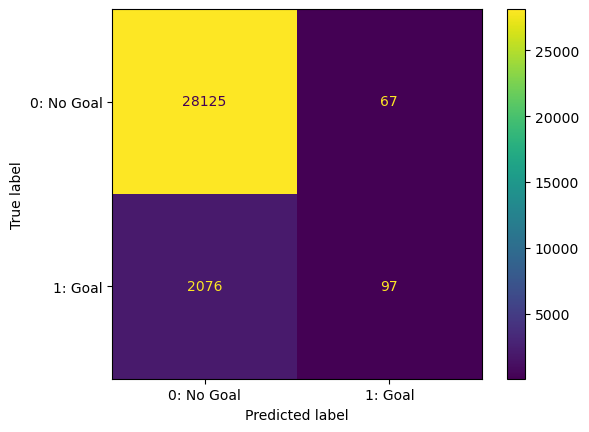

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.59      0.04      0.08      2173

    accuracy                           0.93     30365
   macro avg       0.76      0.52      0.52     30365
weighted avg       0.91      0.93      0.90     30365

Test log loss score: 0.223


In [134]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print(f'Classification report:\n{report}')
print(f'Test log loss score: {log_loss_score:.3f}')

In [138]:
# build baseline trees pipeplin
steps = [('preprocess', ct), 
         ('etc', ExtraTreesClassifier(random_state = 42))]

etc_pipeline = Pipeline(steps)

etc_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'timeSinceLastEvent', 'shotAngleAdjusted',
       'xCordAdjusted', 'yCordAdjusted', 'shotAnglePlusRebound',
       'shotAngleReboundRoyalRoad', 'shotOnEmptyNet',
       'shotAnglePlusReboundSpeed', 'shotRebound', 'shotRush',
       'speedFromLastEv...
       'arenaAdjustedXCordABS', 'homeSkatersOnIce', 'awaySkatersOnIce',
       'awayPenalty1TimeLeft', 'homePenalty1TimeLeft', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('etc', ExtraTreesClassifier(random_state=42))])

In [180]:
pd.DataFrame(zip(feature_names_df[0].values,
                 etc_pipeline[1].feature_importances_)).sort_values(by = 1,
                                                                    ascending = False).head()

,0,1
11,4v3,0.076385
15,6v5,0.072645
14,6v4,0.072068
1,DEFL,0.071031
13,5v4,0.069272


[0.023437   0.07103139 0.06549189 0.06652413 0.06096501 0.02938044
 0.00681208 0.02750122 0.031641   0.00905068 0.00087656 0.07638513
 0.06773191 0.06927245 0.07206777 0.07264527 0.06239928 0.0646988
 0.00803824 0.00767944 0.01447664 0.02090388 0.01907757 0.00534093
 0.00358025 0.00410499 0.00583143 0.00472153 0.00092064 0.00763904
 0.00112151 0.00130616 0.00434063 0.00458095 0.00063914 0.00122749
 0.00394309 0.00066152 0.00195293]


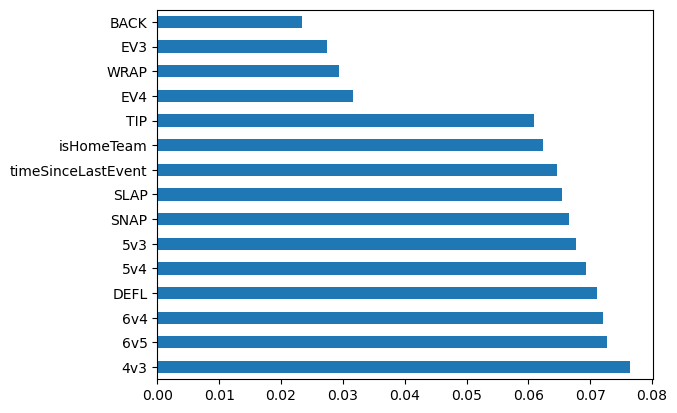

In [305]:
print(etc_pipeline[1].feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(etc_pipeline[1].feature_importances_, feature_names_df[0].values)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [140]:
# Predict using the pipeline 
y_pred = etc_pipeline.predict(X_test)

#Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, etc_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the AUC-ROC score for the test set
log_loss_score = log_loss(y_test, etc_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

Test accuracy: 0.929
Test F1 score: 0.544
Test AUC-ROC score: 0.759
Test log loss score: 0.295


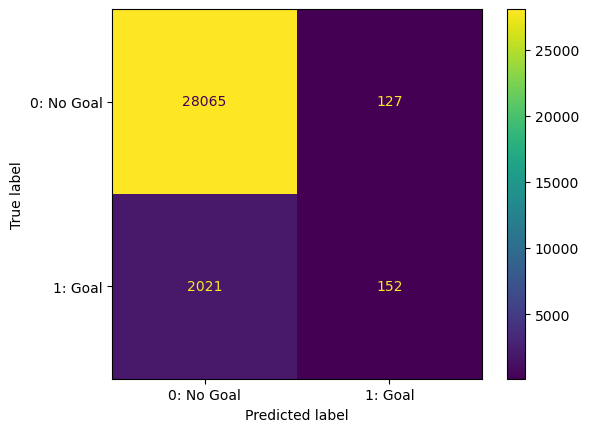

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.54      0.07      0.12      2173

    accuracy                           0.93     30365
   macro avg       0.74      0.53      0.54     30365
weighted avg       0.91      0.93      0.90     30365

Test log loss score: 0.295


In [141]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print(f'Classification report:\n{report}')
print(f'Test log loss score: {log_loss_score:.3f}')

In [145]:
scoring = ['neg_log_loss', 'accuracy']
scores = []
models = []

In [ ]:
# # Parameters
# c = [0.1, 1, 10, 100]
# max_iter = [100, 1000, 10000]
# solver = ['liblinear']
# penalty = ['l1', 'l2']

# logreg_params = {
#     'logreg__C': c,
#     'logreg__max_iter': max_iter,
#     'logreg__solver': solver,
#     'logreg__penalty': penalty
# }

# steps = [('preprocess', ct),
#         ('smote', ct), 
#          ('logreg', LogisticRegression(random_state = 42))]

# # Model
# logreg_top_model_pipe = Pipeline(steps)
# logreg_top_model = GridSearchCV(estimator=logreg_top_model_pipe, param_grid=logreg_params, scoring='neg_log_loss', cv=5, verbose=0)
# logreg_top_model.fit(X_train, y_train)

# # Displaying Data
# y_pred = logreg_top_model.predict(X_test)
# logreg_top_score = logreg_top_model.score(X_test, y_test)

# # Model Selection
# for i in range(0, 11):
#     print(f"Model {i}. Current Top Score: {logreg_top_score}")
        
#     # Split X and y
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    
#     # Model Building
#     logreg_cur_pipe = Pipeline(steps=steps)
#     logreg_cur_gs = GridSearchCV(estimator=logreg_cur_pipe, param_grid=logreg_params, scoring='accuracy', cv=5, verbose=0)
#     logreg_cur_gs.fit(X_train, y_train)
    
#     # Comparing and Replacing Data
#     y_pred = logreg_cur_gs.predict(X_test)
#     logreg_cur_score = logreg_cur_gs.score(X_test, y_test)
    
#     if logreg_cur_score > logreg_top_score:
#         logreg_top_model = logreg_cur_gs
#         logreg_top_score = logreg_cur_score

In [246]:
# RandomForestClassifier with smote
steps = [('preprocess', ct),
        ('smote', SMOTE()),
         ('random', RandomUnderSampler()),
         ('rf_clf', RandomForestClassifier())]

rf_clf_smote = Pipeline(steps)

rf_clf_smote.fit(X_train,y_train)
print('test: {}'.format(rf_clf_smote.score(X_test,y_test)))
print('train: {}'.format(rf_clf_smote.score(X_train,y_train)))


test: 0.9233986497612383
train: 0.9999890222080731


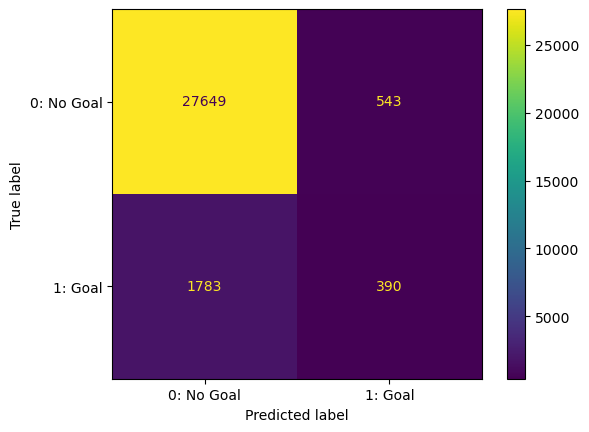

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.54      0.07      0.12      2173

    accuracy                           0.93     30365
   macro avg       0.74      0.53      0.54     30365
weighted avg       0.91      0.93      0.90     30365

Test log loss score: 0.295


In [247]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test,rf_clf_smote.predict(X_test))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print(f'Classification report:\n{report}')
print(f'Test log loss score: {log_loss_score:.3f}')

In [297]:
# Log CV
steps = [('preprocess', ct),
         ('logisticregression', LogisticRegression(max_iter = 10000))]

log_cv_pipeline = Pipeline(steps=steps)

#paramters to test with the grid search
log_params = {'logisticregression__solver' : ['saga','lbfgs'],
                'logisticregression__penalty': ['l2'],
                'logisticregression__C': [.05, 0.1,1]}

log_cv = GridSearchCV(log_cv_pipeline, param_grid=log_params, cv=5,error_score='raise')

In [298]:
log_cv.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [299]:
log_cv.fit(X_train_sample, y_train_sample)


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('numnorm',
                                                                                          StandardScaler())]),
                                                                         Index(['isHomeTeam', 'timeSinceLastEvent', 'shotAngleAdjusted',
       'xCordAdjusted', 'yCordAdjusted', 'shotAnglePlusRebound',
       'shotAngleReboundRoyalRoad', 'shotOnEmptyNet',
       'shotAnglePlusRebound...
                                                                         Pipeline(steps=[('onehotenc',
                                                                                          OneHotEncoder(sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index(['shotType', 'game_strength_state'], dtype='object'))])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.05, 0.1, 1],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['saga', 'lbfgs']})

In [300]:
predsz = log_cv.predict(X_test_sample)

print(classification_report(y_test_sample, predsz))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69      2186
           1       0.69      0.71      0.70      2162

    accuracy                           0.70      4348
   macro avg       0.70      0.70      0.70      4348
weighted avg       0.70      0.70      0.70      4348



## create subset

In [252]:
# check goal values
s21_shots_df['goal'].value_counts() # binary with 1 representing a goal scored

0    112774
1      8697
Name: goal, dtype: int64

In [253]:
# Take subset of majority class
goals_df = shots_df.loc[shots_df['goal'] == 1]

no_goals = shots_df.loc[shots_df['goal'] == 0].sample(8697)
df_sample = pd.concat([no_goals.reset_index(), goals_df.reset_index()],0)
df_sample.shape

(17389, 27)

In [254]:
df_sample= df_sample.drop('index',1)
df_sample

,goal,isHomeTeam,timeSinceLastEvent,shotAngleAdjusted,xCordAdjusted,yCordAdjusted,shotAnglePlusRebound,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotAnglePlusReboundSpeed,shotRebound,shotRush,speedFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,distanceFromLastEvent,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,homeSkatersOnIce,awaySkatersOnIce,awayPenalty1TimeLeft,homePenalty1TimeLeft,offWing,game_strength_state
0,0,1.0,18,0.000000,50,0,0.000000,0,WRIST,0,0.000000,0,0,2.777778,0,0,50.000000,40.000000,0.0,49.0,5,5,0,0,0,EV5
1,0,1.0,8,38.811384,43,37,0.000000,0,WRIST,0,0.000000,0,0,12.218071,-22,-36,97.744565,65.000000,41.0,38.0,5,5,0,0,0,EV5
2,0,0.0,24,6.709837,72,-2,0.000000,0,TIP,0,0.000000,0,0,1.007782,69,22,24.186773,16.000000,2.0,73.0,4,5,0,72,1,state_5v4
3,0,0.0,10,53.130102,74,20,0.000000,0,WRIST,0,0.000000,0,0,0.538516,69,22,5.385165,25.000000,20.0,74.0,5,5,0,0,0,EV5
4,0,0.0,26,41.633539,71,-16,0.000000,0,SLAP,0,0.000000,0,0,2.799250,0,0,72.780492,24.000000,16.0,71.0,3,5,0,44,1,state_5v3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,1,1.0,1,42.954592,60,-27,1.040322,0,WRIST,0,1.040322,1,0,1.000000,60,-28,1.000000,41.000000,28.0,59.0,5,5,0,0,0,EV5
8688,1,0.0,45,19.025606,60,-10,0.000000,0,WRIST,0,0.000000,0,0,2.879043,-69,-22,129.556937,31.000000,10.0,60.0,5,5,0,0,1,EV5
8689,1,1.0,2,5.710593,79,1,0.000000,0,WRIST,0,0.000000,0,0,8.845903,92,13,17.691806,10.049876,1.0,79.0,5,5,0,0,1,EV5
8690,1,0.0,6,62.354025,78,21,0.000000,0,SNAP,0,0.000000,0,0,13.462912,0,0,80.777472,23.706539,21.0,78.0,5,6,0,0,1,state_6v5


In [255]:
X_samp = df_sample.drop('goal',1)
y_samp = df_sample['goal']

In [256]:
X_train_sample,X_test_sample, y_train_sample, y_test_sample = train_test_split(X_samp,y_samp, random_state = 42)

In [258]:
# RandomForestClassifier with smote
steps = [('preprocess', ct),
#         ('smote', SMOTE(sampling_strategy='minority')), 
         ('rf_clf', RandomForestClassifier())]

rf_clf_samp = Pipeline(steps)

rf_clf_samp.fit(X_train,y_train)
print('test: {}'.format(rf_clf_smote.score(X_test_sample,y_test_sample)))
print('train: {}'.format(rf_clf_smote.score(X_train_sample,y_train_sample)))

test: 0.9015639374425023
train: 0.8921095008051529


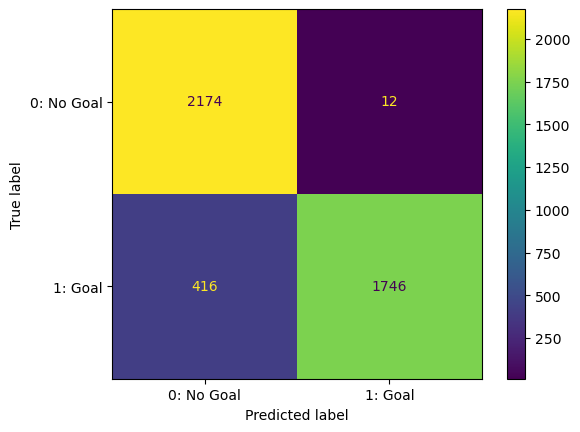

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2186
           1       0.99      0.81      0.89      2162

    accuracy                           0.90      4348
   macro avg       0.92      0.90      0.90      4348
weighted avg       0.92      0.90      0.90      4348

Test log loss score: 0.295


In [262]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test_sample, rf_clf_smote.predict(X_test_sample))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test_sample, rf_clf_smote.predict(X_test_sample))
print(f'Classification report:\n{report}')
print(f'Test log loss score: {log_loss_score:.3f}')

In [373]:
# Predict using the pipeline 
y_pred = rf_clf_samp.predict(X_test_sample)

#Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test_sample, y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test_sample, y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test_sample, rf_clf_samp.predict_proba(X_test_sample)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the AUC-ROC score for the test set
log_loss_score = log_loss(y_test_sample, rf_clf_samp.predict_proba(X_test_sample)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

Test accuracy: 0.896
Test F1 score: 0.895
Test AUC-ROC score: 0.969
Test log loss score: 0.473


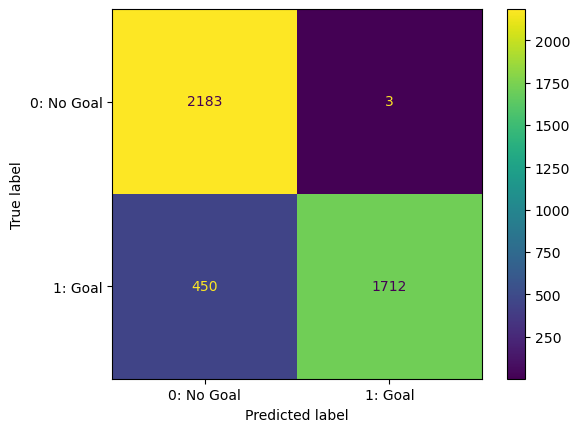

Classification report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2186
           1       1.00      0.79      0.88      2162

    accuracy                           0.90      4348
   macro avg       0.91      0.90      0.89      4348
weighted avg       0.91      0.90      0.89      4348

Test log loss score: 0.473


In [374]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test_sample, rf_clf_samp.predict(X_test_sample))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test_sample, rf_clf_samp.predict(X_test_sample))
print(f'Classification report:\n{report}')
print(f'Test log loss score: {log_loss_score:.3f}')

In [265]:
preds1 = rf_clf_smote.predict(X_test)
confusion_matrix(y_test, preds1)
print(classification_report(y_test,preds1))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     28192
           1       0.42      0.18      0.25      2173

    accuracy                           0.92     30365
   macro avg       0.68      0.58      0.61     30365
weighted avg       0.90      0.92      0.91     30365

